## Introduction

This project shall explore time series trends within 3 sets of data: Brent Crude Oil Price, iShares Global Clean Energy ETF and US GDP Data.

We shall build a vector auto-regressive model, which is a multivariate time series model that relates current observations of a time series data to past observations of itself and other time series. An impulse response function will also provide a view of how this model will react in relation to an isolated shock of a specific variable.

This is not an academic project, more so casual data exploration.

In [1]:
library(ggplot2)
library(lmtest)
library(tidyr)
library(vars)
library(tidyverse)
library(lubridate)
library(readxl)
library(dplyr)
library(tseries)
ICLN <- read_excel("../input/PersonalProject/ICLN.xlsm")
head(ICLN)
GDP_2008 <- read_excel("../input/PersonalProject/GDP_2008.xlsx")
head(GDP_2008)
Oil_Price_2008 <- read_excel("../input/PersonalProject/Oil_Price_2008.xlsx")
head(Oil_Price_2008)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: MASS

Loading required package: strucchange

Loading required package: sandwich

Loading required package: urca

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ readr   2.1.3      ✔ stringr 1.4.1 
✔ purrr   0.3.5      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ stringr::boundary() masks strucchange::boundary()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::select()     masks MASS::select()

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Date,Close
<dttm>,<dbl>
2008-10-01,21.99
2008-11-01,19.17
2008-12-01,21.39
2009-01-01,20.27
2009-02-01,15.23
2009-03-01,17.50


Month,GDP
<dttm>,<dbl>
2008-10-01,15366.61
2009-01-01,15187.48
2009-04-01,15161.77
2009-07-01,15216.65
2009-10-01,15379.16
2010-01-01,15456.06


Month,Brent Oil price
<dttm>,<dbl>
2008-10-01,55.06291
2009-01-01,44.22259
2009-04-01,58.86684
2009-07-01,68.33648
2009-10-01,74.89829
2010-01-01,76.67484


The iShares Global Clean Energy (ICLN) index, is an ETF that tracks the investment results of an index composed of global equities in the clean energy sector with exposure to companies that produce energy in solar, wind and other renewable sources. We shall interpret this as an index that tracks the stock returns of global energy equities. This is taken from iShares.

The Brent Crude Oil is the benchmark and acts as a price index for the world's leading basin crude oils, taken from trading economics.

US GDP data measures U.S output, GDP is defined as the market value of goods and services produced by labor located in the United States. This is taken from St Louis Federal Reserve Economic Data.

## Data Transformation

We see that US GDP data and Brent Crude Oil is on a quarterly basis, whilst ICLN is daily. We shall transform the latter into quarterly data for the sake of uniformity.

In [2]:
Oil_Price_2008$Month <- as.Date.POSIXct(Oil_Price_2008$Month)
Oil_Price_2008$Month <- as.yearqtr(Oil_Price_2008$Month)

ICLN$Date <- as.Date.POSIXct(ICLN$Date)
ICLN$QDate <- as.yearqtr(ICLN$Date)
ICLN_Qtr <- aggregate(ICLN$Close, by = list(ICLN$QDate), FUN = first)

GDP_2008$Month <- as.Date.POSIXct(GDP_2008$Month)
GDP_2008$Month <- as.yearqtr(GDP_2008$Month)

head(ICLN_Qtr)
head(GDP_2008)
head(Oil_Price_2008)

,Group.1,x
,<yearqtr>,<dbl>
1,2008 Q4,21.99
2,2009 Q1,20.27
3,2009 Q2,21.05
4,2009 Q3,23.35
5,2009 Q4,20.43
6,2010 Q1,19.24


Month,GDP
<yearqtr>,<dbl>
2008 Q4,15366.61
2009 Q1,15187.48
2009 Q2,15161.77
2009 Q3,15216.65
2009 Q4,15379.16
2010 Q1,15456.06


Month,Brent Oil price
<yearqtr>,<dbl>
2008 Q4,55.06291
2009 Q1,44.22259
2009 Q2,58.86684
2009 Q3,68.33648
2009 Q4,74.89829
2010 Q1,76.67484


We have to normalize our data, as each of the time series values are on different scales The impulse response function will cause inflated/deflated reactions if we use absolute values. Therefore, by transforming time series into log-differences we will be analyzing the relative change in the time series data across time periods.


Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.”


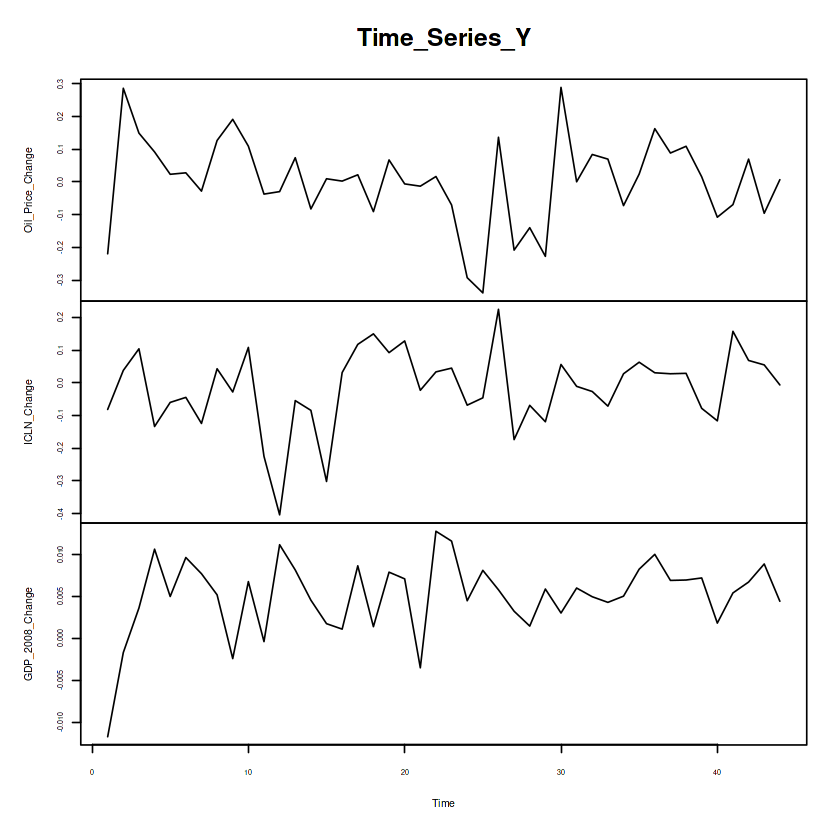

In [3]:
Oil_Price_2008$`Brent Oil price` <- log(Oil_Price_2008$`Brent Oil price`)
Oil_Price_Change  <- diff(Oil_Price_2008$`Brent Oil price`)

ICLN_Qtr$x <- log(ICLN_Qtr$x)
ICLN_Change <- diff(ICLN_Qtr$x)

GDP_2008$GDP <- log(GDP_2008$GDP)
GDP_2008_Change <- diff(GDP_2008$GDP)

Time_Series_Y <- data_frame(Oil_Price_Change, ICLN_Change, GDP_2008_Change)
par(cex.axis=0.5,cex.lab=0.5,cex=0.5)
plot.ts(Time_Series_Y)

An important assumption of a VAR model, is that the variables in the model are stationary.

Stationarity is defined as when a time series does not depend on the period in time at which the time series data point is observed. This essentially means that time series with trend or seasonality cannot be considered stationary due to the fact that their behavior can be attributed to a function of time.

The Adult-Dickey Fuller test (ADF) is a good test to detect non-stationarity within time-series.

The null hypothesis of the ADF Test is that the series is non-stationary.

The alternative seeks to disprove the null hypothesis, and states that the series in stationary.

Our p-values for the ADF test of log change in GDP states that we are able to conclude within a 99% confidence interval that these time series are stationary.

In [4]:
adf.test(Oil_Price_Change)
adf.test(GDP_2008_Change)
adf.test(ICLN_Change)


	Augmented Dickey-Fuller Test

data:  Oil_Price_Change
Dickey-Fuller = -2.2764, Lag order = 3, p-value = 0.4644
alternative hypothesis: stationary


Warning message in adf.test(GDP_2008_Change):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  GDP_2008_Change
Dickey-Fuller = -4.3, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  ICLN_Change
Dickey-Fuller = -2.9118, Lag order = 3, p-value = 0.2128
alternative hypothesis: stationary


## Time Series Decomposition

We shall decompose the time-series for ICLN and Oil, and adjust it to take out seasonality in order to enforce stationarity.

Warning message in adf.test(ICLN_Adj):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ICLN_Adj
Dickey-Fuller = -5.2297, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(Oil_Adj):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  Oil_Adj
Dickey-Fuller = -5.3439, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


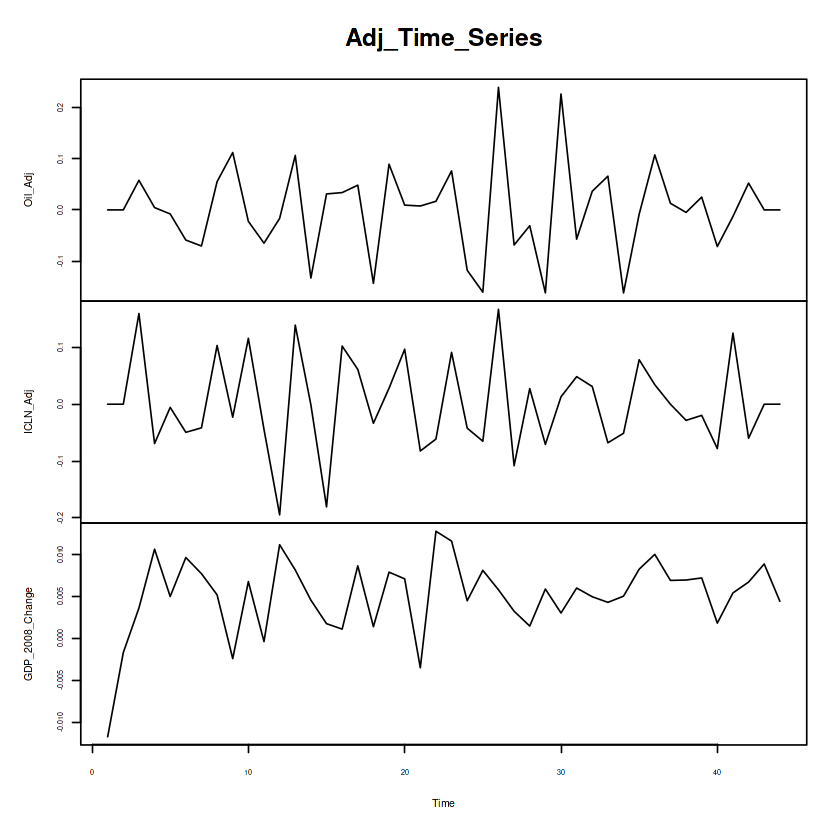

In [5]:
Oil_Price_ts <- ts(Oil_Price_Change, frequency = 4, c(2009,1))
Oil_Dec <- decompose(Oil_Price_ts)
Oil_Adj <- Oil_Price_ts - Oil_Dec$seasonal - Oil_Dec$trend
Oil_Adj[is.na(Oil_Adj)] <- 0

ICLN_Ts <- ts(ICLN_Change, frequency = 4, c(2009,1))
ICLN_dec <- decompose(ICLN_Ts)
ICLN_Adj <- ICLN_Change - ICLN_dec$seasonal - ICLN_dec$trend
ICLN_Adj[is.na(ICLN_Adj)] <- 0

Adj_Time_Series <- data_frame(Oil_Adj, ICLN_Adj, GDP_2008_Change)
par(cex.axis=0.5,cex.lab=0.5,cex=0.5)
plot.ts(Adj_Time_Series)
adf.test(ICLN_Adj)
adf.test(Oil_Adj)

## Model Preparation

We now see that the ADF test for the seasonally and trend adjusted time series for ICLN has a p value of approximately 0.01 This means that we can say within a 95% confidence interval that this time series is stationary.

Before we build the model, we must select the optimal lag length to be used. We shall set the maximum lag at 4 as we intend to only test for the relationship of variables lagged as far as 1 year (4 quarters).

In [6]:
VAR_Y <- data.frame(Oil_Adj, GDP_2008_Change, ICLN_Adj)
Lag_Order <- VARselect(VAR_Y, lag.max = 4)
summary(Lag_Order$selection)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.75    2.00    2.25    2.50    4.00 

Based on the Aikake Information Criteria (AIC) the optimal lag length is 4, we shall use this lag-length for our VAR model

We shall now combine these time-series into a data-frame and use them as the Y variables for our VAR model.

In [7]:
AIC <- VAR(VAR_Y, lag.max = 4, season = NULL, exog = NULL, type="none")
summary(AIC)


VAR Estimation Results:
Endogenous variables: Oil_Adj, GDP_2008_Change, ICLN_Adj 
Deterministic variables: none 
Sample size: 40 
Log Likelihood: 288.877 
Roots of the characteristic polynomial:
0.9425 0.8282 0.8282 0.7828 0.7828 0.7725 0.7725 0.6847 0.6847 0.6507 0.6507 0.1454
Call:
VAR(y = VAR_Y, type = "none", exogen = NULL, lag.max = 4)


Estimation results for equation Oil_Adj: 
Oil_Adj = Oil_Adj.l1 + GDP_2008_Change.l1 + ICLN_Adj.l1 + Oil_Adj.l2 + GDP_2008_Change.l2 + ICLN_Adj.l2 + Oil_Adj.l3 + GDP_2008_Change.l3 + ICLN_Adj.l3 + Oil_Adj.l4 + GDP_2008_Change.l4 + ICLN_Adj.l4 

                   Estimate Std. Error t value Pr(>|t|)    
Oil_Adj.l1          -0.8765     0.1905  -4.601 8.26e-05 ***
GDP_2008_Change.l1   2.3728     2.6694   0.889 0.381641    
ICLN_Adj.l1          0.1262     0.2121   0.595 0.556641    
Oil_Adj.l2          -0.9085     0.2243  -4.050 0.000367 ***
GDP_2008_Change.l2  -5.2788     2.7242  -1.938 0.062801 .  
ICLN_Adj.l2          0.4314     0.2351   1.835 0.0

## Significant Coefficients

The are plenty of insights we can extract from each equation, however, the relationship that we will choose to examine further is the one where log stock returns of ICLN is the Y variable. We see that the p-value is less than 0.05, indicating that this model provides a better fit than a null model with no variables and an intercept. The low r-squared however, indicates that there are potentially other variables that can be included into the model that may provide a better fit.

The lagged variable of log GDP change in the model is statistically significant for 2-quarter lags. This allows us to conclude within the 90% confidence interval, that log changes in GDP during 2 quarters back are associated with current log changes changes in the ICLN ETF. We are unable to do so however, for the rest of the lag periods as they statistically insignificant.

There is also statistical significance for several periods of lagged log changes in oil price as a coefficient, we see that there is significant negative correlation between the lagged log changes in oil price from past 2,3 and 4 quarters ago within the 90 and 95% confidence interval.

We also see notable statistical significance between current values of the ETF, and its past values as the log changes in the index for previous first, second and fourth quarters are within the 99% confidence interval.

We can therefore conclude that lagged log changes in the GDP,lagged log oil price change and lagged log stock returns all have a notable relationship with the ETF's current log returns.A lasting negative relationship between log oil price changes and current log stock returns can be seen with higher precision in comparison to lag GDP changes.

We also must recognize that there are potentially other variables we could have added in addition to our existing endogenous variables into the model that will give better fit. This is a reduced form VAR model, which identifies current shocks to each time-series variables as an error term, thus we will choose not to explicitly model for the contemporaneous interdependence between the variables as we are only concerned with the relationship between each variable and lagged values wihin the scope of this project.

## Model Diagnostics

A VAR model includes these following assumptions :

1.  The residuals show no autocorrelation
2.  The variables are stationary
3.  Residuals show no heteroscedasticity
4.  Residuals are normally distributed.


	Edgerton-Shukur F test

data:  Residuals of VAR object AIC
F statistic = 0.88315, df1 = 45, df2 = 33, p-value = 0.6549

$serial

	Edgerton-Shukur F test

data:  Residuals of VAR object AIC
F statistic = 0.88315, df1 = 45, df2 = 33, p-value = 0.6549




	ARCH (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 151.94, df = 144, p-value = 0.3089

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 151.94, df = 144, p-value = 0.3089



$JB

	JB-Test (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 2.1683, df = 6, p-value = 0.9036


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 1.4207, df = 3, p-value = 0.7007


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 0.74765, df = 3, p-value = 0.8619


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 2.1683, df = 6, p-value = 0.9036


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 1.4207, df = 3, p-value = 0.7007


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object AIC
Chi-squared = 0.74765, df = 3, p-value = 0.8619




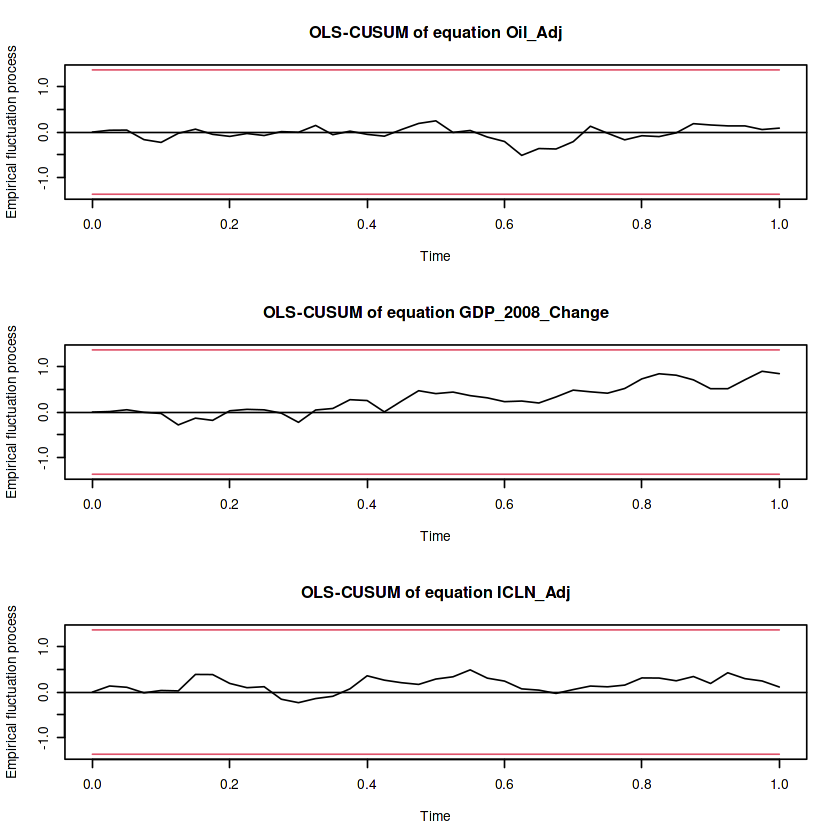

In [8]:
Serial1 <- serial.test(AIC, lags.pt = 4, type = "ES")
Serial1

Arch <- Arch1 <- arch.test(AIC, lags.multi = 4, multivariate.only = TRUE)
Arch1

Norm1 <- normality.test(AIC, multivariate.only = TRUE)
Norm1 

Stability1 <- stability(AIC, type = "OLS-CUSUM")
plot(Stability1)

The Edgerton Shukur F-test, which is suitable for small to medium-sized samples, tests for serial correlation between residuals, with the null hypothesis being that the residuals show no serial correlation. Our p value is above the 0.05 threshold so we can uphold this null hypothesis.

The ARCH test checks for heteroscedasticity within residuals, which indicates where there are clusters of large volatility in residuals during certain periods in time. The null hypothesis is that the residuals have no heteroscedasticity. Our p value is above the 0.05 threshold so we can uphold this null hypothesis.

The normality test comes with 3 tests, the kurtosis tests for if the distribution has a heavy/light tail, the skewness tests for the symmetry of the distribution while the JB-test is able to test for both such attributes. We see that we are unable to disprove the null hypothesis for any, which states that the distribution does not have these attributes and thus we can conclude that our residuals are normally distributed.

The stability test checks for the presence of structural breaks, which is the unexpected change over time in the parameters of models. We see that the cumulative sum of residuals across the time period are within the red bands for all variables, which indicate that there are no structural breaks.

We see that our model is able to validate the assumptions listed above, and also have no structural breaks that may cause forecasting errors.

## Impulse Response Function Interpretation

The Impulse Response Function visually portrays the impact to the VAR model of a positive shock/change to an input of one of the variables. We can discern it as a representation of the how the coefficients of an equation for a Y variable in the VAR model relate to the movement of the said variable over time from a shock in one of its inputs.

The positive shock is described to be a shock of 1 standard deviation from the mean of a given input on the system.

We shall examine the response of the log stock returns of the ICLN index from a one standard deviation shock in the log GDP change, log Oil Price change and its own log stock returns in 3 separate scenarios.

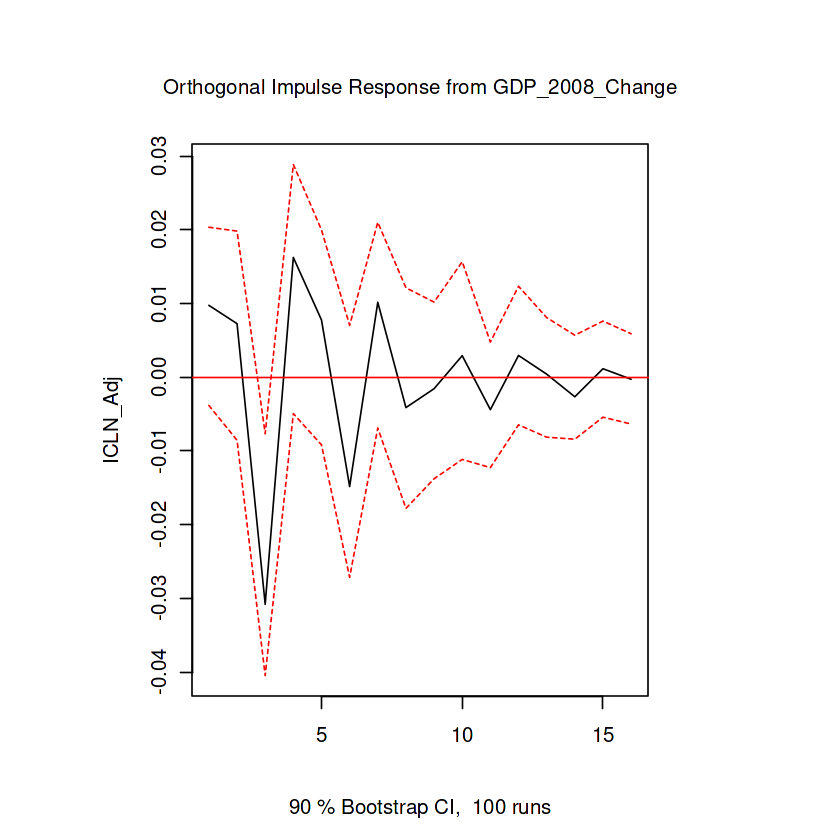

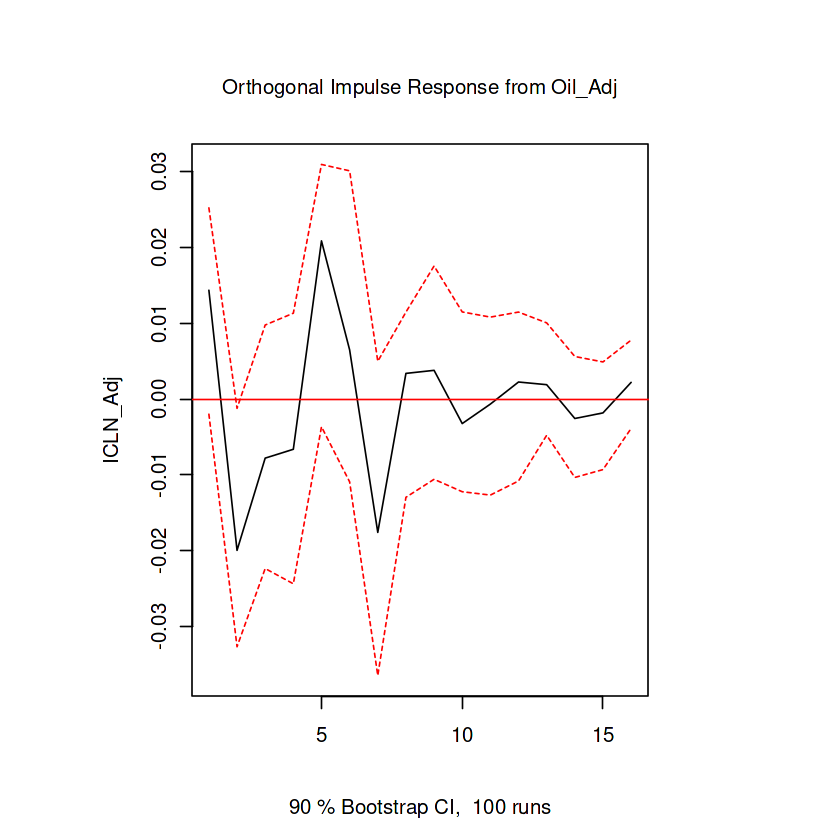

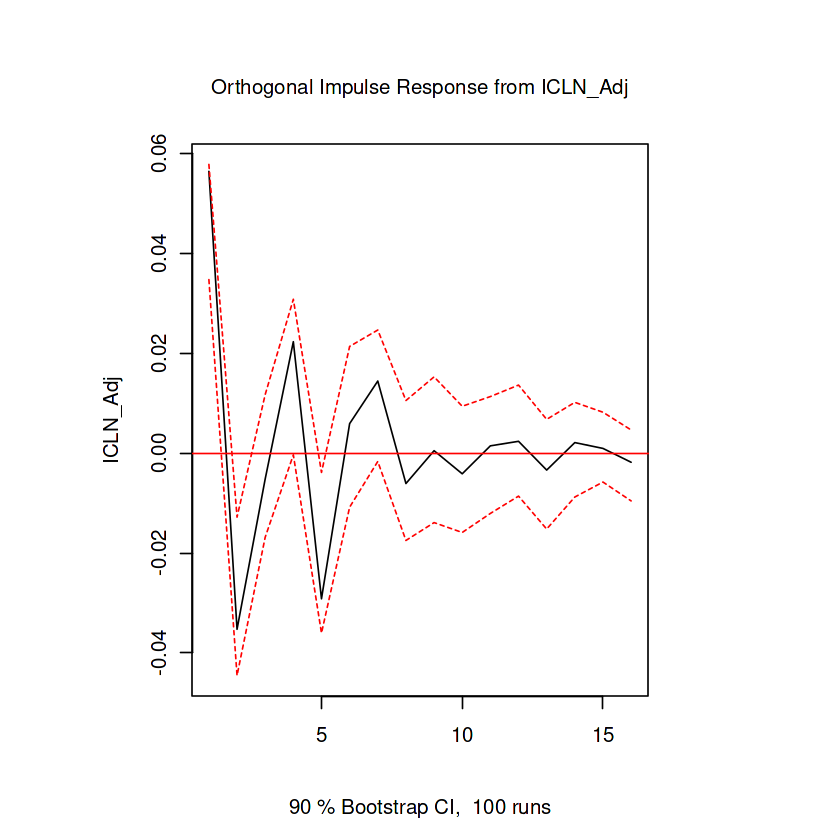

In [9]:
IRF <- irf(AIC, impulse = "GDP_2008_Change", response = "ICLN_Adj", n.ahead = 15, boot = T, cumulative = FALSE, ci =0.9)
plot(IRF)
IRF <- irf(AIC, impulse = "Oil_Adj", response = "ICLN_Adj", n.ahead = 15, cumulative = FALSE, ci =0.9)
plot(IRF)
IRF <- irf(AIC, impulse = "ICLN_Adj", response = "ICLN_Adj", n.ahead = 15,cumulative = FALSE, ci =0.9)
plot(IRF)

Since this is a reduced-form VAR model and we have not explicitly identified contemporaneous relationships between variables as coefficients in our model, the starting point of the response variable in an IRF visual may be at a point higher/lower than 0. We are more interested in the relative movement beyond this starting point the lagged coefficients are what is specified in the model.

The red bands describe the 90% confidence interval at which the behavior of the response variable is estimated, therefore this is a function of the standard errors of the coefficient estimates in the model.

There is a higher level of uncertainty for the response of stock returns from a shock in GDP change in the quarter immediately after, relative to the second quarter where the log stock returns exhibit a strong downwards trend as a result of this shock. This decline is alleviated in the following third quarter with an upwards trend. We are able to infer this broad trend of cyclicality slowly diminishes over time until eventually converging close to 0. Reconciling the high level of uncertainty during the first quarter after the shock and from the 3rd quarter after the shock on wards with our findings, a macro level insight we can deduce is that positive GDP shocks will cause a negative pull on stock returns of clean energy equities 2 quarters later that is reversed for an overall aggregate positive impact in the short-term (1-year time frame) based on our VAR model. This short-term impact, however, subsides across the long-term.

We are able to see a declining trend in stock returns in the 1st quarter, after a positive shock in the rate of change in Oil price with high precision. 4 quarters after this shock we see that there is an aggregate positive impact on stock returns. There is cyclicality present in this IRF as well but not to the degree of our earlier graph. Thus, positive shocks to the rate of Oil price changes cause a negative pull on stock returns of clean energy equities in the 1st quarter after but reversed for an overall aggregate positive impact in the short-term based on our VAR model.The stock returns however is associated with an apparent decline immediately after this 1-year time frame, and starts to subside in the long-term.

A downtrend in the following first quarter is also seen with high level of confidence in a positive shock of clean energy stock returns, which is also immediately reversed in the second. We see that this positive shock will cause an aggregate negative impact on returns in the short-term, that is alleviated immediately following the 1-year time frame and eventually converging close to 0.

In conclusion, we see that despite an immediate downwards pull in returns from all three positive shocks there is an overall positive impact on returns in the 1-year point. Possible reasons that could be attributed to these short-term effects is that the market prices in negative scenarios/outlooks in the first or second quarter after these shocks but adjusts to a more positive outlook on the performance of the clean energy sector as time passes into through a one-year period.

## Causality Inference

A granger causality test calculates a Wald Statistic, which is used to disprove the null hypothesis that no lags of a variable X are statistically significant (If 3 lags with coefficients B then B1 = B2 = B3 = 0) in forecasting for a variable Y. This helps us to discern if within a reasonable level of confidence we are able to conclude that lags of a certain variable contribute towards reducing forecasting error.

The null hypothesis therefore, is that lagged variables of X are not significant in forecasting variable Y.

The alternative hypothesis being that lagged variables of X are significant in forecasting variable Y.

In [10]:
grangertest(ICLN_Adj~GDP_2008_Change, order = 4, VAR_Y)
grangertest(ICLN_Adj~Oil_Adj, order = 4, VAR_Y)

,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,31,NA,NA,NA
2,35,-4,1.218103,0.3231631


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,31,NA,NA,NA
2,35,-4,2.220487,0.0896648


From the granger tests, we are able to see that we are not able to conclude within a 90% or 95% confidence interval that lagged GDP changes provide significant reduction in forecasting errors when included in the model. On the other hand, we are able to see within the 90% confidence interval that lagged rates of change in Oil price are significant in forecasting for the stock returns of clean energy equities.

This provides further depth to our analysis, as we must consider that there are other variables that can potentially be added into the model that will allow for reduced forecasting errors from our current model. We are able to uphold our insights of the relationship between Oil price rate shocks and the response of stock returns, however we are unable to do so for our relationship between GDP rate shocks and responses of stock returns with the same level of confidence.